# Implementação do Random Forest

In [82]:
TRAINING_DATASET_SOURCE = '../training_data.csv'  # Since we are one directory up, we should go down one directory to import the datasets
TEST_DATASET_SOURCE = '../test_data.csv'

In [83]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# Definição dos dados de teste e de treino

In [84]:
print(train_df.shape, test_df.shape)

(5000, 13) (1206, 12)


In [85]:
train_df['incidents'].value_counts()

None         2028
High         1073
Low           718
Very_High     603
Medium        578
Name: incidents, dtype: int64

In [86]:
#count_class0, count_class1, count_class2, count_class3, count_class4 = train_df['incidents'].value_counts().to_frame()

incidents_count = train_df['incidents'].value_counts()

max_count = incidents_count.max()

print('Max value count:', max_count)

df_classes = []
for category, counts in zip(incidents_count.index, incidents_count):
    #print(category, counts)
    df_classes.append(train_df[train_df['incidents'] == category])

df_classes_over = []

for category in df_classes:
    df_classes_over.append(category.sample(max_count, replace=True))

df_test_over = pd.concat(df_classes_over, axis=0)

print(df_test_over['incidents'].value_counts())


Max value count: 2028
None         2028
High         2028
Low          2028
Very_High    2028
Medium       2028
Name: incidents, dtype: int64


In [87]:
dropped_columns = ['city_name', 'avg_precipitation', 'magnitude_of_delay', 'record_date', 'affected_roads']

X = df_test_over.drop([*dropped_columns, 'incidents'], axis=1)
y = df_test_over['incidents']

all_features = X.columns.tolist()

In [88]:
X

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain
3482,0,LIGHT,19.0,1021.0,56.0,1.0,Sem Chuva
4383,0,DARK,7.0,1024.0,77.0,2.0,Sem Chuva
350,0,DARK,8.0,1015.0,92.0,0.0,Sem Chuva
760,0,DARK,12.0,1022.0,91.0,1.0,Sem Chuva
729,39,DARK,13.0,1013.0,93.0,1.0,Sem Chuva
...,...,...,...,...,...,...,...
1938,0,LIGHT,16.0,1012.0,76.0,3.0,Sem Chuva
1111,0,DARK,5.0,1031.0,93.0,2.0,Sem Chuva
4730,0,DARK,14.0,1019.0,90.0,0.0,Sem Chuva
1077,0,LIGHT,16.0,1016.0,82.0,1.0,Sem Chuva


In [89]:
numerical_features = [column for column, dtype in zip(X.columns, X.dtypes)
                      if dtype.kind in ['i', 'f']]

categorical_features = [column for column, dtype in zip(X.columns, X.dtypes)
                        if dtype.kind not in ['i', 'f']]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2000)

In [91]:
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy='median'),
        MinMaxScaler(),
    ), numerical_features),

    (make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(categories='auto', handle_unknown='ignore'),
    ), categorical_features),
)

In [92]:
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif

preprocessor_best = make_pipeline(preprocessor, VarianceThreshold(), SelectKBest(f_classif, k='all'))

In [93]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators=100))

In [94]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

0.9964778810932657

In [95]:
RF_Model.score(X_test, y_test)

0.9102564102564102

## Hyperparameter Tuning

In [96]:
import numpy as np

n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=3)]

max_features = ['auto', 'sqrt']

max_depth = [2, 6, 12, 20, 30, 40, 50]

min_samples_split = [2, 5, 30]

min_samples_leaf = [1, 2, 50]

bootstrap = [True, False]

criterions = ["gini", "entropy", "log_loss"]

In [97]:
param_grid = {
    'randomforestclassifier__n_estimators': n_estimators,
    'randomforestclassifier__max_features': max_features,
    'randomforestclassifier__max_depth': max_depth,
    'randomforestclassifier__min_samples_split': min_samples_split,
    'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    'randomforestclassifier__bootstrap': bootstrap,
    'randomforestclassifier__criterion': criterions
}

param_grid

{'randomforestclassifier__n_estimators': [100, 150, 200],
 'randomforestclassifier__max_features': ['auto', 'sqrt'],
 'randomforestclassifier__max_depth': [2, 6, 12, 20, 30, 40, 50],
 'randomforestclassifier__min_samples_split': [2, 5, 30],
 'randomforestclassifier__min_samples_leaf': [1, 2, 50],
 'randomforestclassifier__bootstrap': [True, False],
 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}

In [98]:
from sklearn import metrics

print(metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [99]:
rf_RandomGrid = RandomizedSearchCV(estimator=RF_Model, param_distributions=param_grid, cv=5, verbose=3, n_jobs=-1,
                                   n_iter=5, scoring='balanced_accuracy')

In [100]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 641 ms
Wall time: 1.99 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                ['delay_in_seconds',
                                                                                                 'avg_temperature',
                                                                                                 'avg_atm_pressure',
                                                                                                 'avg_humidity',
                                                                                                 'avg_wind_speed']),
                                                                                               ('pipeline-2'...
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': [2,
                                                                              6,
                                                                              12,
                                                                              20,
                                                                              30,
                                                                              40,
                                                                              50],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     50],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      30],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 150,
                                                                                 200]},
                   scoring='balanced_accuracy', verbose=3)

In [101]:
rf_RandomGrid.score(X_train, y_train)

0.9964609892450774

In [102]:
rf_RandomGrid.best_score_

0.8969004738745854

In [103]:
rf_RandomGrid.best_params_

{'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__criterion': 'log_loss',
 'randomforestclassifier__bootstrap': True}

In [104]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['delay_in_seconds',
                                                                    'avg_temperature',
                                                                    'avg_atm_pressure',
                                                                    'avg_humidity',
                                                                    'avg_wind_speed']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['luminosity',
                                                                    'avg_rain'])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectkbest', SelectKBest(k='all'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='log_loss', max_depth=30))])

In [105]:
print(f'Train: {rf_RandomGrid.score(X_train,y_train):.3f}' )
print(f'Test: {rf_RandomGrid.score(X_test,y_test):.3f}' )

Train: 0.996
Test: 0.912


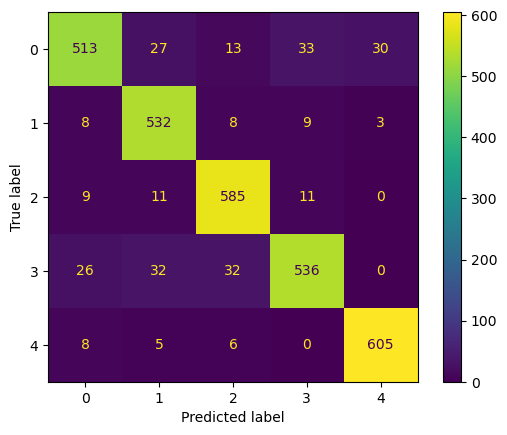

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_RandomGrid.predict(X_test)

cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()